In [1]:
import pickle

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from inceptionresnet import inceptionresnetv2

In [3]:
from object_detection_utils.object_detection_helper import *
from object_detection_utils.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_utils.RetinaNet import RetinaNet
from object_detection_utils.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [4]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
❓ libjpeg-turbo's status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version 5.3.0.post1

*** Pillow-SIMD status
✔ Running Pillow-SIMD 5.3.0.post1

*** CUDA status
✔ Running the latest CUDA 10.0.130 with NVIDIA driver 418.74

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [5]:
torch.cuda.empty_cache()

In [6]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### Check dataset 

In [7]:
path = Path('data/ILSVRC/Data/CLS-LOC')
annotation_path = Path('data/ILSVRC/Annotations/CLS-LOC')

In [8]:
os.listdir(path)

['export',
 'imagenet_199px_object_detection.pkl',
 'imagenet_256px_object_detection.pkl',
 'imagenet_256px_object_detection_smoll.pkl',
 'imagenet_256px_object_detection_smoller.pkl',
 'imagenet_299px_object_detection.pkl',
 'models',
 'test',
 'train',
 'valid']

In [9]:
len(os.listdir(path/'train'))

1000

In [10]:
os.listdir(path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [11]:
len(os.listdir(path/'valid'))

50000

In [12]:
os.listdir(path/'valid')[:5]

['ILSVRC2012_val_00000007.JPEG',
 'ILSVRC2012_val_00000008.JPEG',
 'ILSVRC2012_val_00000009.JPEG',
 'ILSVRC2012_val_00000010.JPEG',
 'ILSVRC2012_val_00000011.JPEG']

In [13]:
len(os.listdir(path/'test'))

100000

In [14]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00026354.JPEG',
 'ILSVRC2012_test_00000007.JPEG',
 'ILSVRC2012_test_00000008.JPEG',
 'ILSVRC2012_test_00000009.JPEG',
 'ILSVRC2012_test_00000010.JPEG']

In [15]:
os.listdir(annotation_path)[:5]

['train', 'valid']

In [16]:
len(os.listdir(annotation_path/'train'))

1000

In [17]:
os.listdir(annotation_path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [18]:
os.listdir(annotation_path/'train/n01440764')[:5]

['n01440764_4167.xml',
 'n01440764_10548.xml',
 'n01440764_10569.xml',
 'n01440764_10587.xml',
 'n01440764_10592.xml']

In [19]:
len(os.listdir(annotation_path/'valid'))

50000

In [20]:
os.listdir(annotation_path/'valid')[:5]

['ILSVRC2012_val_00000006.xml',
 'ILSVRC2012_val_00000007.xml',
 'ILSVRC2012_val_00000008.xml',
 'ILSVRC2012_val_00000009.xml',
 'ILSVRC2012_val_00000010.xml']

In [21]:
os.listdir(annotation_path/'valid')[0]

'ILSVRC2012_val_00000006.xml'

### extract annotations

In [22]:
#path

In [23]:
#import xml.etree.ElementTree as ET

In [24]:
#fnames = []
#lbl_bboxes = []

In [25]:
#val_path = f'{annotation_path}/valid/'
#train_path = f'{annotation_path}/train/'

In [26]:
#with open('data/imagenet_synsets.txt', 'rb') as class_name_file:
#    class_names = class_name_file.readlines()

In [27]:
#class_names = [cl.decode("utf-8").split(' ', 1) for cl in class_names]
#class_names = [[cl[0], ','.join(cl[1][:-1].split(',')[:2])] for cl in class_names]
#class_names = dict(class_names)

In [28]:
#dict(list(class_names.items())[:3])

In [29]:
#for annotation in os.listdir(val_path):   
#    bboxes = []
#    root = ET.parse(val_path+annotation).getroot()
#
#    bbox_tag = root.findall('object/bndbox')
#    xmin = [r.find('xmin').text for r in bbox_tag]
#    ymin = [r.find('ymin').text for r in bbox_tag]
#    xmax = [r.find('xmax').text for r in bbox_tag]
#    ymax = [r.find('ymax').text for r in bbox_tag]
#        
#    for i in range(0, len(bbox_tag)):
#        bboxes.append([float(ymin[i]), float(xmin[i]), float(ymax[i]), float(xmax[i])])
#
#    obj_tag = root.findall('object')
#    category = [r.find('name').text for r in obj_tag]
#    category = [class_names[cat] for cat in category]
#    
#    fname_tag = root.findall('filename')
#    fname = fname_tag[0].text + '.JPEG' 
#    fnames += ['valid' + '/' + fname]
#
#    lbl_bboxes.append([bboxes, category])

In [30]:
#len(lbl_bboxes)

In [31]:
#lbl_bboxes

In [32]:
#for folder in os.listdir(train_path):
#    for annotation in os.listdir(train_path + folder):
#        bboxes = []
#        root = ET.parse(f'{train_path}{folder}/{annotation}').getroot()
#
#        bbox_tag = root.findall('object/bndbox')
#        xmin = [r.find('xmin').text for r in bbox_tag]
#        ymin = [r.find('ymin').text for r in bbox_tag]
#        xmax = [r.find('xmax').text for r in bbox_tag]
#        ymax = [r.find('ymax').text for r in bbox_tag]
#
#        for i in range(0, len(bbox_tag)):
#            bboxes.append([float(ymin[i]), float(xmin[i]), float(ymax[i]), float(xmax[i])])
#
#        obj_tag = root.findall('object')
#        category = [r.find('name').text for r in obj_tag]
#        category = [class_names[cat] for cat in category]
#
#        fname_tag = root.findall('filename')
#        fname = fname_tag[0].text + '.JPEG' 
#        fnames += ['train/' + folder + '/' + fname]
#        lbl_bboxes.append([bboxes, category])

In [33]:
#fname2bbox = dict(zip(fnames, lbl_bboxes))

In [34]:
#with open('fname2bbox.p', 'wb') as fp:
#    pickle.dump(fname2bbox, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('fname2bbox.p', 'rb') as fp:
    fname2bbox = pickle.load(fp)

In [36]:
#coco = untar_data(URLs.COCO_SAMPLE)
#images, lbl_bbox = get_annotations(coco/'annotations/train_sample.json')
#img2bbox = dict(zip(images, lbl_bbox))

In [37]:
#dict(list(img2bbox.items())[0:2])

In [38]:
dict(list(fname2bbox.items())[:4])

{'valid/ILSVRC2012_val_00000006.JPEG': [[[204.0, 105.0, 279.0, 358.0]],
  ['garter snake, grass snake']],
 'valid/ILSVRC2012_val_00000007.JPEG': [[[75.0, 89.0, 268.0, 498.0]],
  ['porcupine, hedgehog']],
 'valid/ILSVRC2012_val_00000008.JPEG': [[[163.0, 14.0, 328.0, 181.0],
   [81.0, 176.0, 223.0, 331.0],
   [2.0, 77.0, 155.0, 236.0],
   [219.0, 163.0, 374.0, 355.0]],
  ['bakery, bakeshop',
   'bakery, bakeshop',
   'bakery, bakeshop',
   'bakery, bakeshop']],
 'valid/ILSVRC2012_val_00000009.JPEG': [[[203.0, 36.0, 315.0, 373.0]],
  ['mousetrap']]}

In [39]:
len(fname2bbox)

594546

### define metric 

In [40]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### for the full ILSV2017 classification dataset

In [41]:
def path2fn(path):
    if 'val' in path:
        return re.search('\w*\/\w*\.JPEG$', path).group(0)
    else:
        return re.search('\w*\/\w*\/\w*\.JPEG$', path).group(0)

In [42]:
get_y_func = lambda o: fname2bbox[path2fn(o)]

In [43]:
size = 256

In [44]:
train_df = pd.DataFrame(data=list(fname2bbox.keys()))

In [45]:
data_bunch = (ObjectItemList.from_df(train_df, path=path)
                           #.use_partial_data(0.6)
                           .split_by_rand_pct(valid_pct=0.1, seed=21)
                           .label_from_func(get_y_func)
                           .transform(get_transforms(), tfm_y=True, size=size)
                           .databunch(bs=32, collate_fn=bb_pad_collate))

In [46]:
data_bunch = data_bunch.normalize(imagenet_stats)

In [47]:
data_bunch.save('imagenet_256px_object_detection_smoller.pkl')

### if the databunch has been saved

In [48]:
#size = 256

In [49]:
#data_bunch = load_data('data/ILSVRC/Data/CLS-LOC', 'imagenet_256px_object_detection_smoll.pkl', 
#                       collate_fn=bb_pad_collate, bs=8, num_workers=8)

### quick look at the images

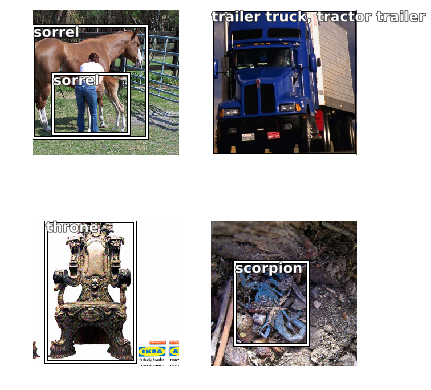

In [50]:
data_bunch.show_batch(rows=2, figsize=(6,6))

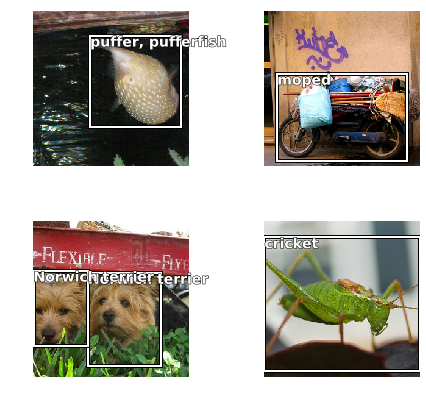

In [51]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

## creating anchors

In [52]:
anchors = create_anchors(sizes=[(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.5, 0.6, 1, 1.25,])

In [53]:
#anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.35, 0.5, 0.6])

In [54]:
len(anchors)

4032

In [55]:
#fig,ax = plt.subplots(figsize=(15,15))
#ax.imshow(image2np(data_bunch.valid_ds[0][0].data))
#
#for i, bbox in enumerate(anchors[:12]):
#    bb = bbox.numpy()
#    x = (bb[0] + 1) * size / 2 
#    y = (bb[1] + 1) * size / 2 
#    w = bb[2] * size / 2
#    h = bb[3] * size / 2
#    
#    rect = [x,y,w,h]
#    draw_rect(ax,rect)

In [56]:
#all_boxes, all_labels = show_anchors_on_images(data_bunch, anchors, figsize=(25,25))

### create learner with inceptionresnetv2 (the pytorch model is already pretrained on imagenet)

In [57]:
data_bunch.train_ds.c

1000

In [58]:
n_classes = data_bunch.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet34, True, -2) 

model = RetinaNet(encoder, n_classes=data_bunch.train_ds.c, n_anchors=12, sizes=[16,8,4], chs=128, 
                  final_bias=0, n_conv=4)

In [59]:
#voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:])
learn = Learner(data_bunch, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[])

In [60]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [61]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [62]:
# time per epoch:
# 0:41 for resnet18 0.1 dataset
# 2:40 for resnet18 0.5 dataset
# 4:00 for resnet18 full dataset
# 4:20 for resnet34 full dataset
# 5:10 for resnet34 full dataset

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-05


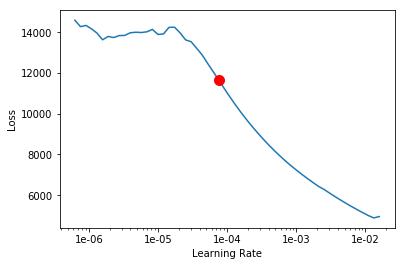

In [64]:
learn.recorder.plot(suggestion=True)

In [65]:
lr = 2e-4

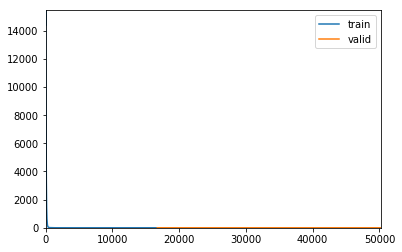

In [66]:
learn.fit_one_cycle(3, max_lr=slice(lr), div_factor=35)

In [67]:
learn.save('256px_object_detection_frozen_smoll');

In [68]:
#learn.load('256px_object_detection_frozen_smoll');

In [69]:
learn.unfreeze()

In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


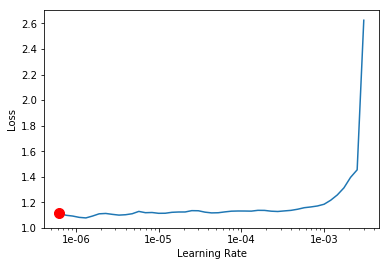

In [71]:
learn.recorder.plot(suggestion=True)

In [72]:
lr = 1e-4

In [71]:
#lrs = learn.lr_range(slice(lr,lr))
#lrs

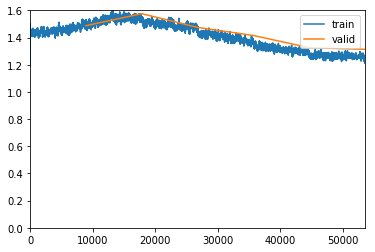

In [74]:
learn.fit_one_cycle(6, max_lr=lr, div_factor=50)

In [75]:
learn.save('256px_object_detection_smoll');

## Visualize result

In [63]:
learn.load('256px_object_detection_smoll');

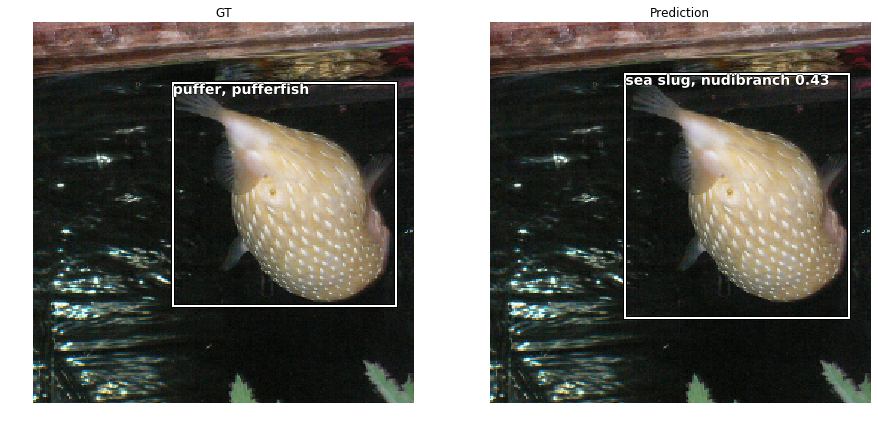

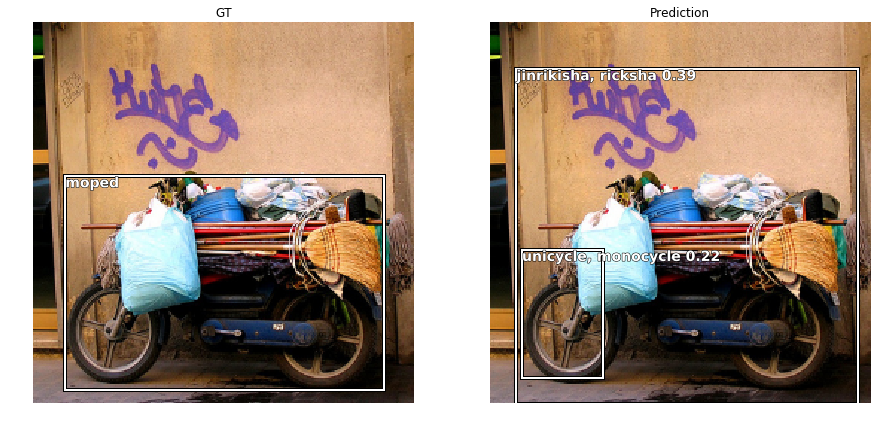

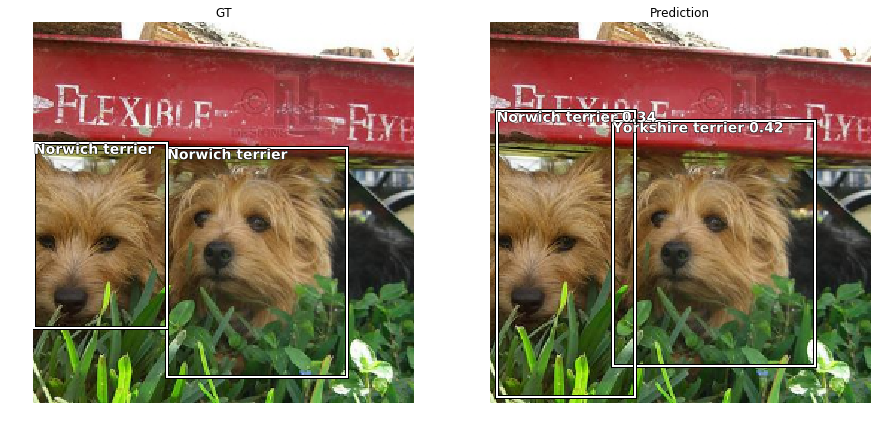

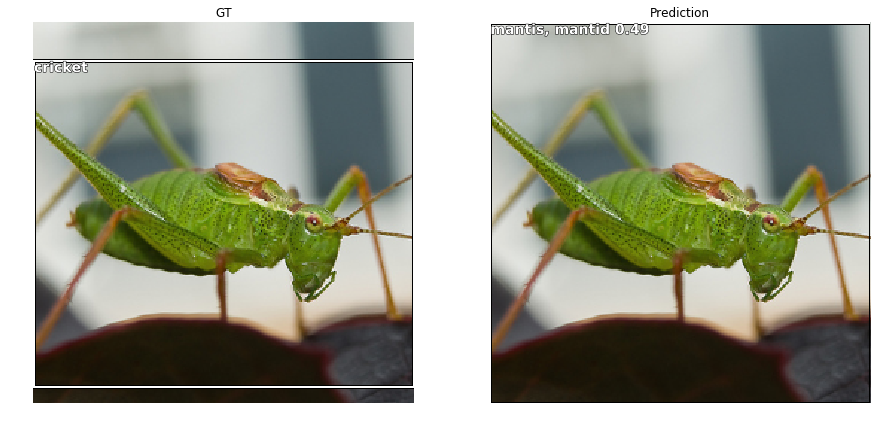

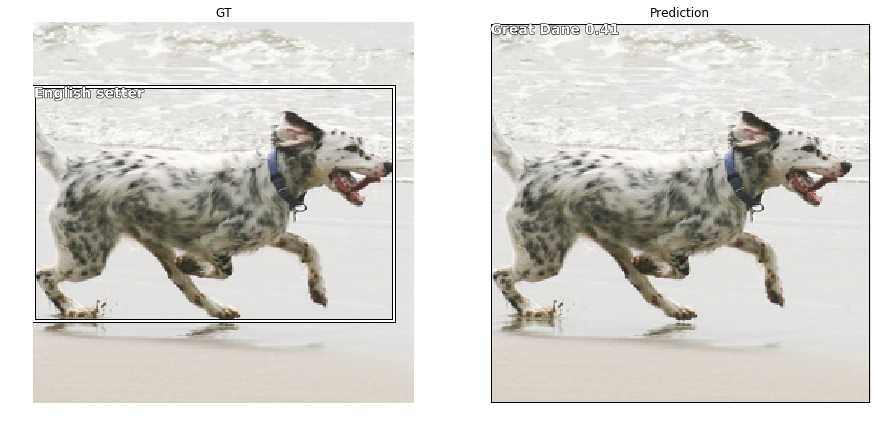

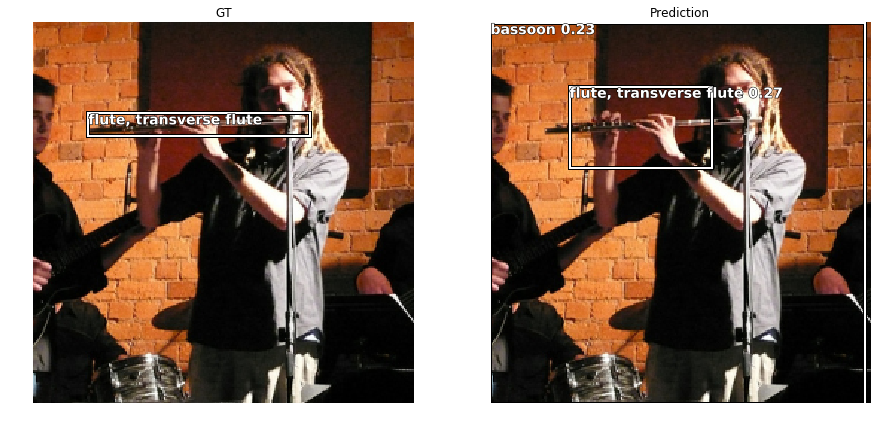

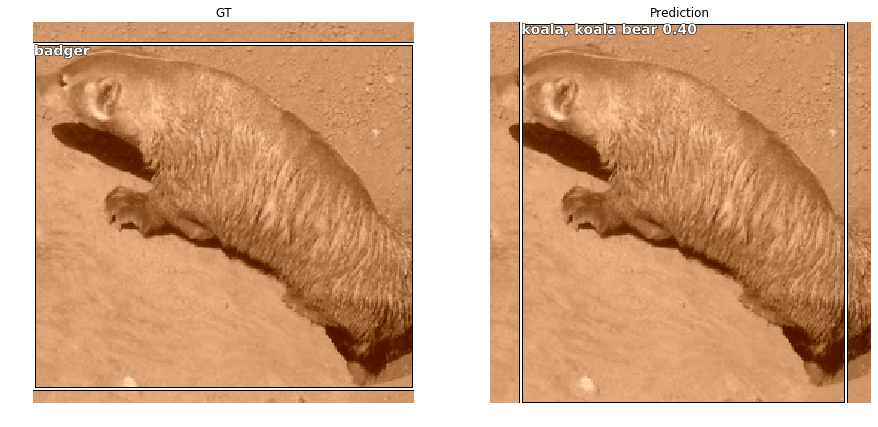

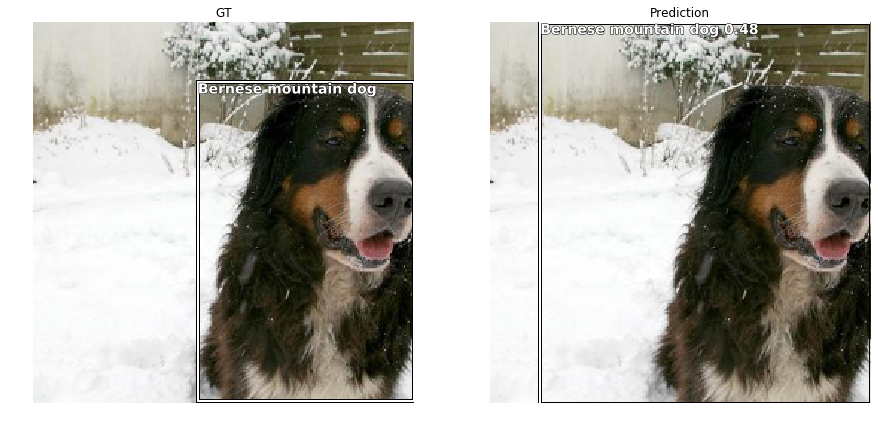

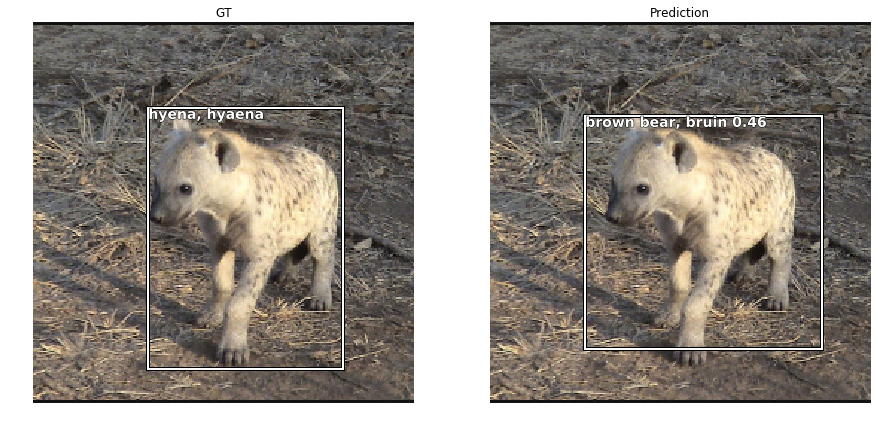

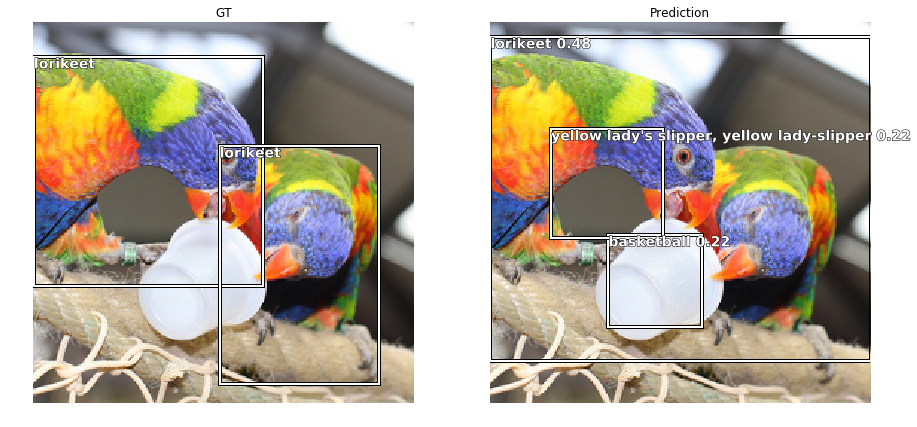

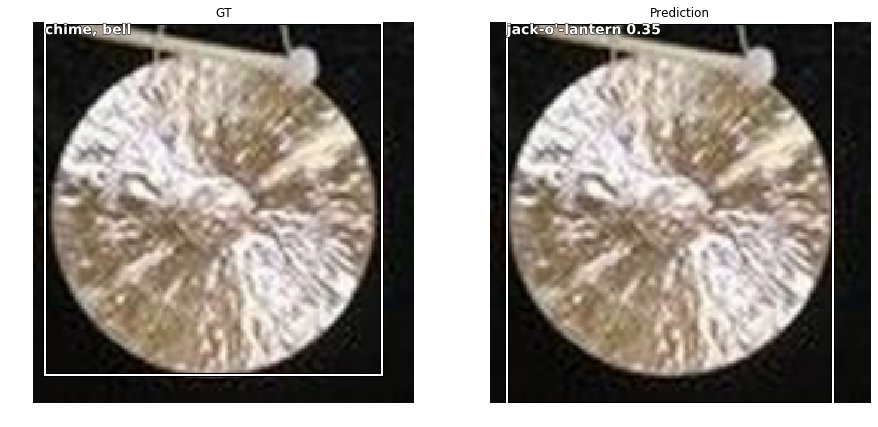

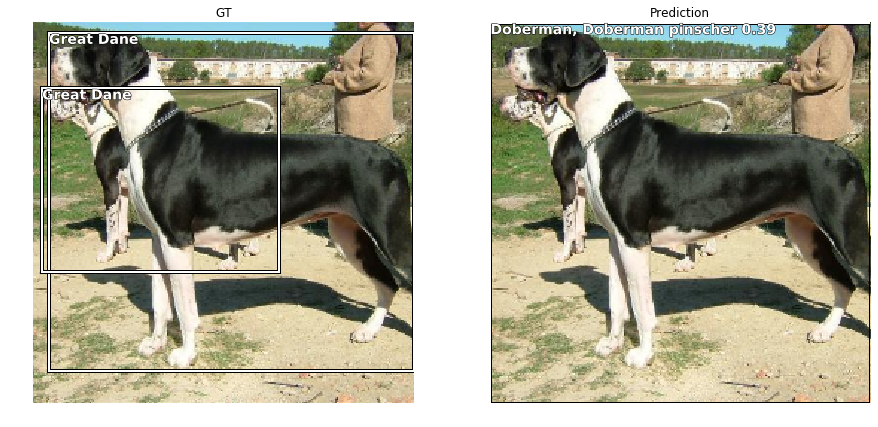

In [73]:
show_results_side_by_side(learn, anchors, detect_thresh=0.2, nms_thresh=0.1, image_count=12) #frozen training

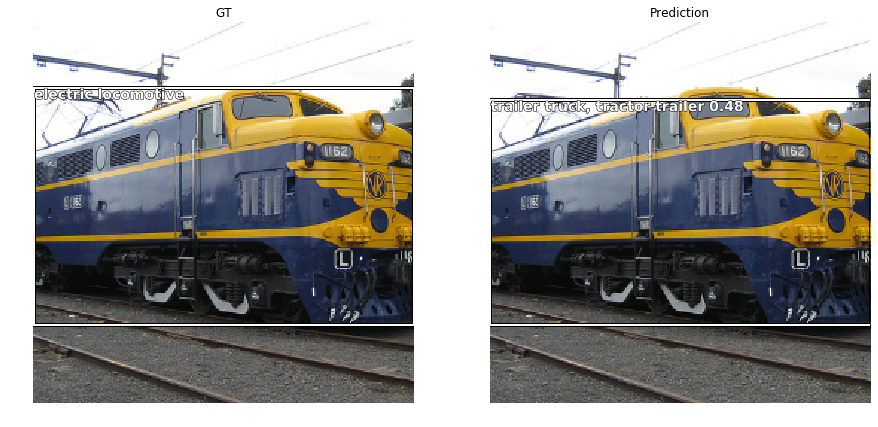

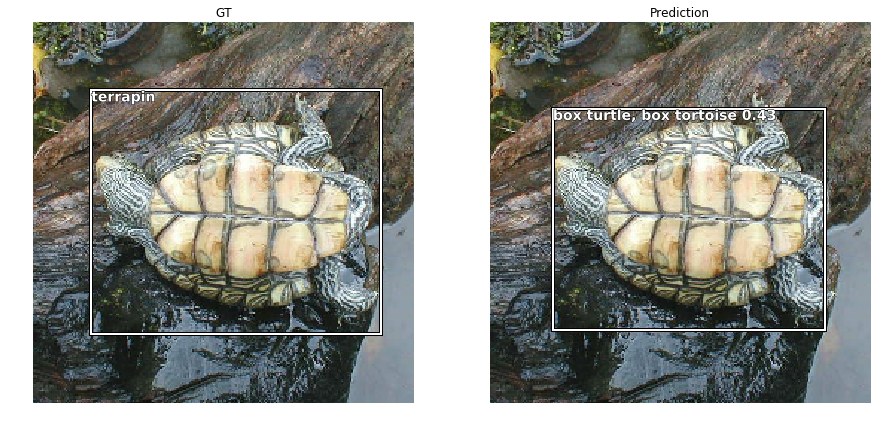

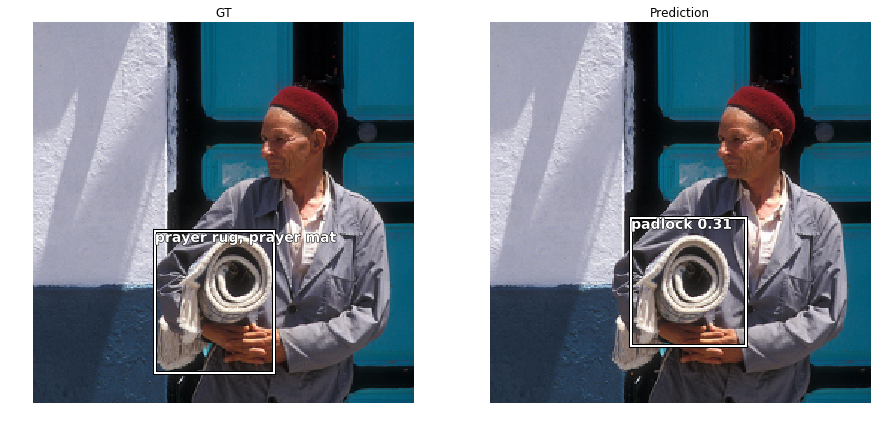

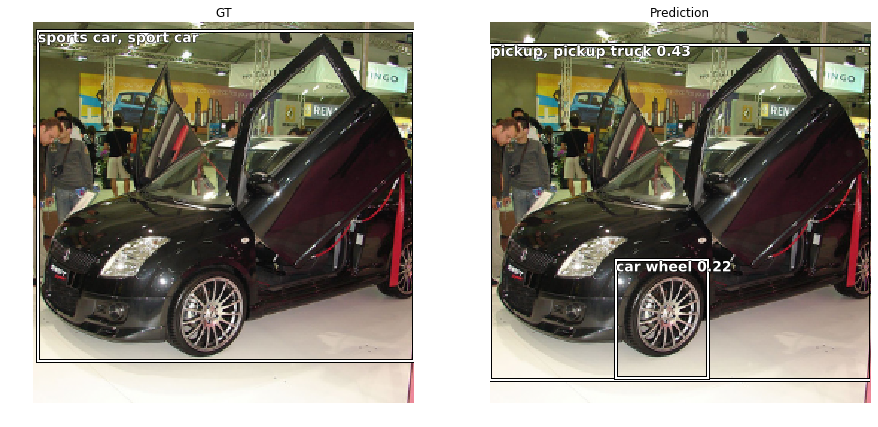

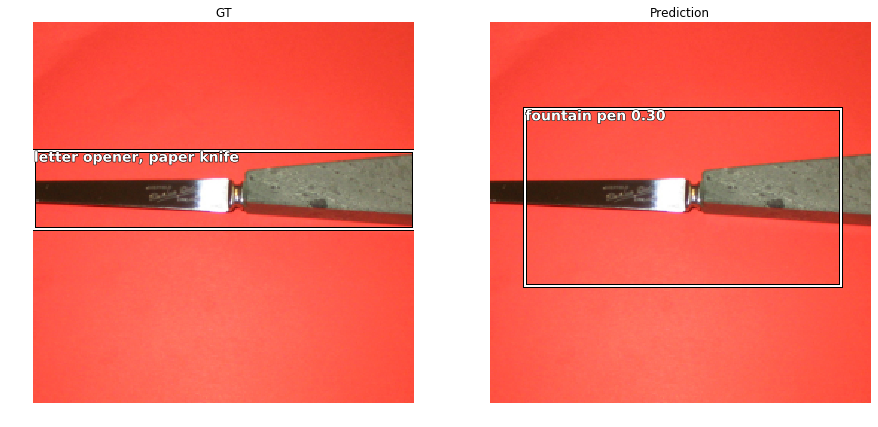

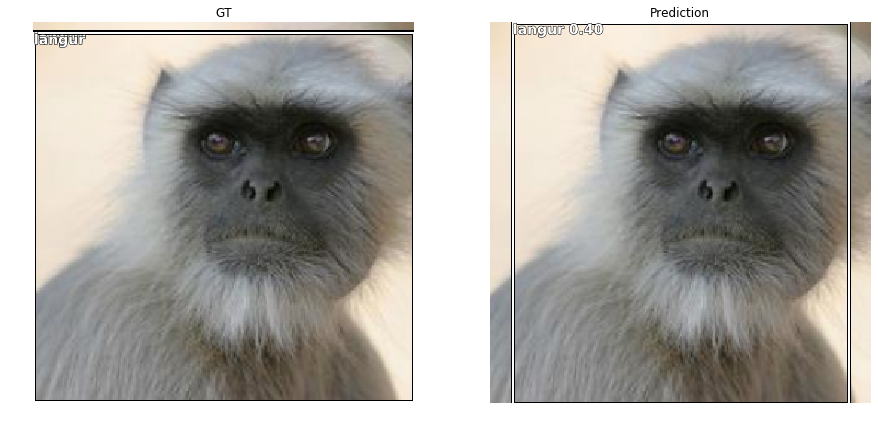

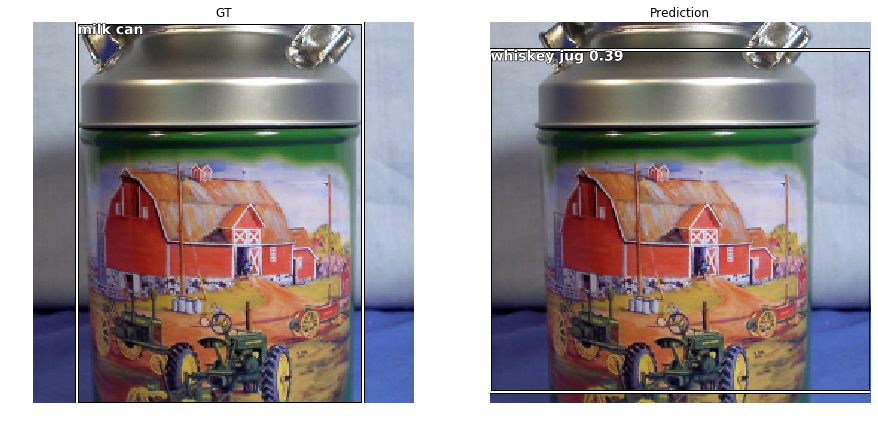

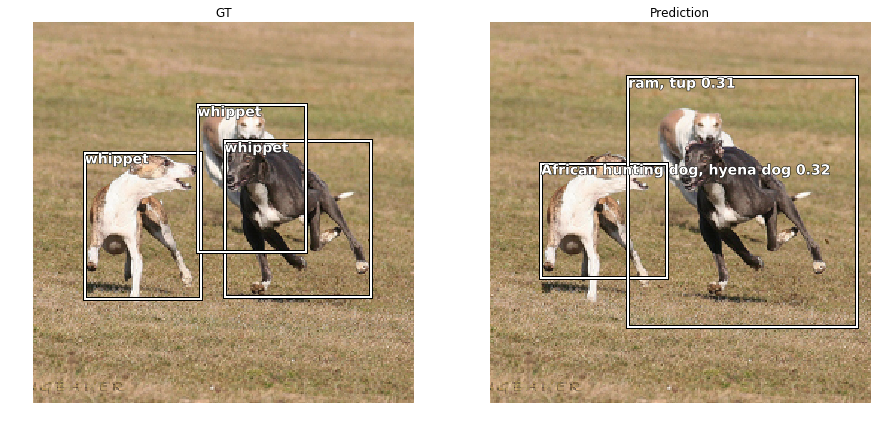

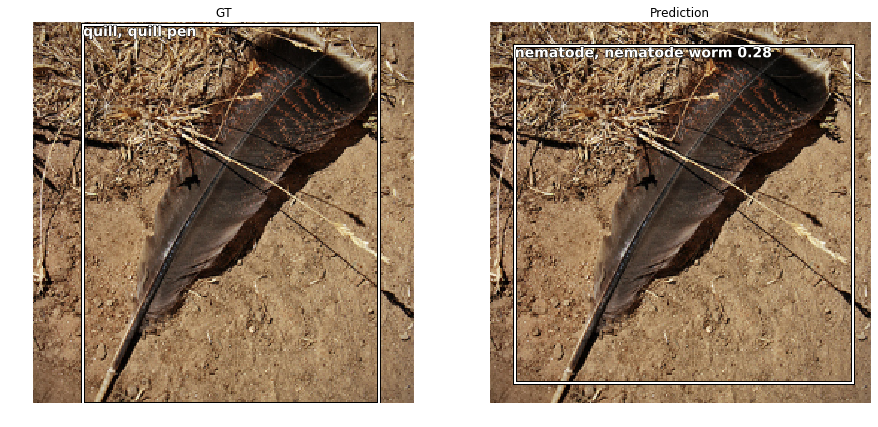

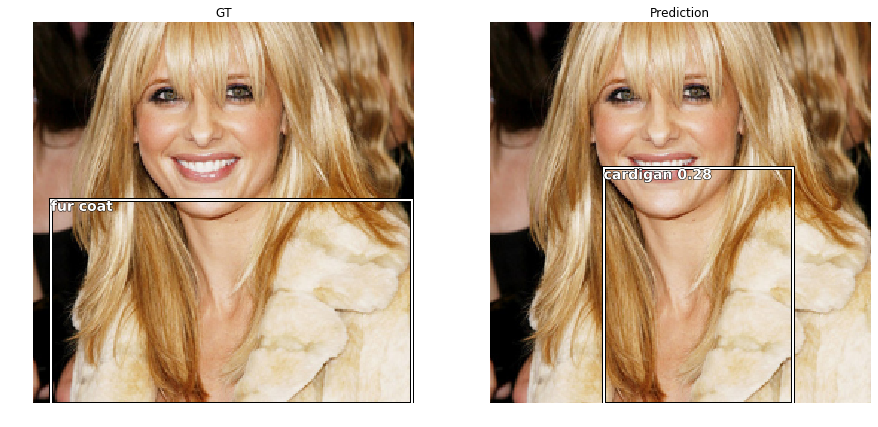

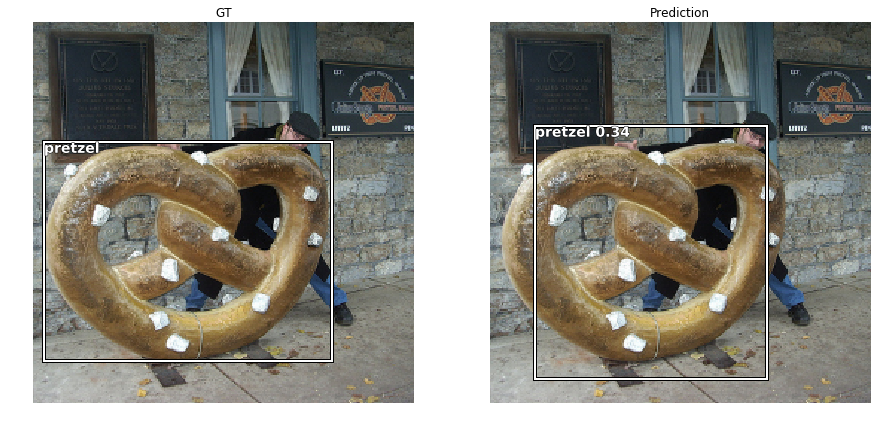

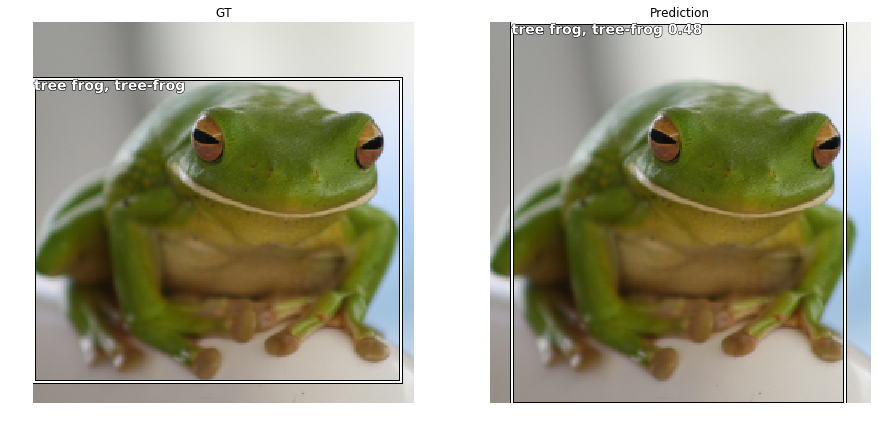

In [64]:
show_results_side_by_side(learn, anchors, detect_thresh=0.2, nms_thresh=0.1, image_count=12) #full training

In [74]:
learn.export('resnet34_bbox_frozen.pkl')

## extract prediction (test for webapp)

In [1]:
from fastai.vision import *

In [2]:
from object_detection_utils.object_detection_helper import *
from object_detection_utils.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_utils.RetinaNet import RetinaNet
from object_detection_utils.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [3]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [4]:
os.listdir(path/'valid')[:10]

['ILSVRC2012_val_00000007.JPEG',
 'ILSVRC2012_val_00000008.JPEG',
 'ILSVRC2012_val_00000009.JPEG',
 'ILSVRC2012_val_00000010.JPEG',
 'ILSVRC2012_val_00000011.JPEG',
 'ILSVRC2012_val_00000012.JPEG',
 'ILSVRC2012_val_00000013.JPEG',
 'ILSVRC2012_val_00000014.JPEG',
 'ILSVRC2012_val_00000015.JPEG',
 'ILSVRC2012_val_00000016.JPEG']

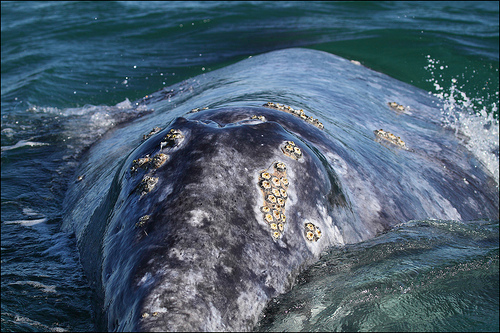

In [5]:
img = open_image(path/'valid/ILSVRC2012_val_00000016.JPEG')
img

In [6]:
detect_thresh=0.25
nms_thresh=0.1

In [7]:
anchors = create_anchors(sizes=[(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.5, 0.6, 1, 1.25,])

In [10]:
learn = load_learner(path = path, file='resnet34_bbox_frozen.pkl')

In [11]:
classes = [i for i in learn.data.train_ds.y.classes[1:]]

In [12]:
tfms_image = img.apply_tfms(get_transforms()[0]).resize(256)

In [13]:
pred = learn.model(tfms_image.data.unsqueeze(0).cuda())

In [14]:
class_pred, bbox_pred = pred[:2]

In [15]:
#if hasattr(learn.data, 'stats'):
#    tfms_image = Image(learn.data.denorm(tfms_image.data))
#else:
#    tfms_image = Image(tfms_image)
bbox_pred, scores, preds = process_output(class_pred[0], bbox_pred[0], anchors, detect_thresh=0.25)

In [16]:
with open('data/imagenet_synsets.txt', 'rb') as class_name_file:
    class_names = class_name_file.readlines()
class_names = [cl.decode("utf-8").split(' ', 1) for cl in class_names]
classes = [[cl[0], ','.join(cl[1][:-1].split(',')[:2])] for cl in class_names]

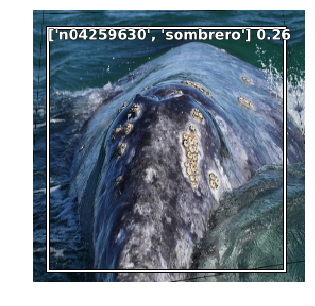

In [17]:
if bbox_pred is not None:
    to_keep = nms(bbox_pred, scores, nms_thresh)
    bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

t_sz = torch.Tensor([*tfms_image.size])[None].cpu()

if bbox_pred is not None:
    bbox_pred = to_np(rescale_boxes(bbox_pred, t_sz))
    # change from center to top left
    bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2

#this has to be replaced by actually drawing the bb on the image and sending it to the frontend 
show_preds(tfms_image, bbox_pred, preds, scores, classes, figsize=(5,5)) 